In [31]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import r2_score
from IPython.display import display, HTML

import sys
sys.path.append('/home/badhon/Documents/thesis/thesis-codes/')
from helpers import utils
from helpers import evaluation
from classes.WheatDataset import WheatDataset
from classes.Evaluator import Evaluator

%matplotlib inline

#### Define some paths

In [32]:
path_config = '/home/badhon/Documents/thesis/AerialDetection/configs/my/faster_rcnn_r50_fpn_1x_dota1_5.py'
path_work_dir = '/home/badhon/Documents/thesis/AerialDetection/work_dirs/faster_rcnn_r50_fpn_1x_dota1_5'

path_images = "/home/badhon/Documents/thesis/Data and Scripts from AL/global-WHEAT-final/train/usas_minipam/"
path_splits = "/home/badhon/Documents/thesis/AerialDetection/data/wheat_competition/"
path_test_images = path_splits + 'test/images/'

path_updated_test_json = path_splits + "test/test.json"
path_old_test_json = (
    "/home/badhon/Documents/thesis/AerialDetection/data/wheat/test/test_hbb.json"
)

#### Load Updated Test Dataset

In [33]:
test_dataset = WheatDataset(path_updated_test_json, path_images)
test_dataset.load_dataset()

#### Load Old Test Dataset

In [34]:
test_dataset_old = WheatDataset(path_old_test_json, path_images)
test_dataset_old.load_dataset()

#### Get ground truth boxes for both datasets

In [35]:
all_gts = test_dataset.get_dataset_bboxes('XYP')
all_gts_old = test_dataset_old.get_dataset_bboxes('XYP')

## Evaluate HBB Model (Epoch 2000) 

#### Create evaluator

In [36]:
hbb_evaluator = Evaluator(path_config, path_work_dir, 2000)

#### Evaluate the model against updated and old ground truths

In [37]:
eval_res = hbb_evaluator.evaluate_image_folder(path_test_images, None, all_gts)
eval_res_old = hbb_evaluator.evaluate_image_folder(path_test_images, None, all_gts_old)

In [38]:
print("Evaluation of HBB Model Against Updated Test Dataset: ")
hbb_evaluator.print_summary(eval_res)

print("\nEvaluation of HBB Model Against Old Test Dataset: ")
hbb_evaluator.print_summary(eval_res_old)

Evaluation of HBB Model Against Updated Test Dataset: 
tp:  515
fp:  130
fn:  70
gt:  585
ap:  0.8403151017710525

Evaluation of HBB Model Against Old Test Dataset: 
tp:  513
fp:  132
fn:  73
gt:  586
ap:  0.8381762638247894


#### Precision-Recall Curve

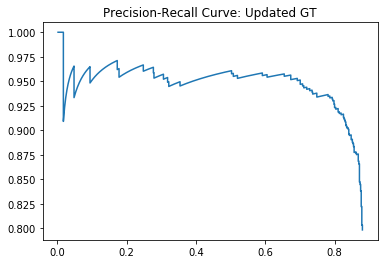

In [39]:
utils.draw_plot_xy(eval_res['rec'], eval_res['prec'], "Precision-Recall Curve: Updated GT")

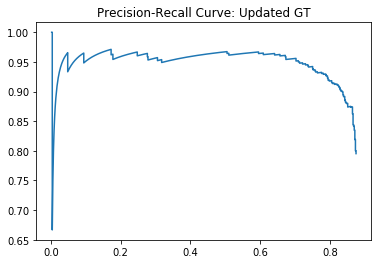

In [40]:
utils.draw_plot_xy(eval_res_old['rec'], eval_res_old['prec'], "Precision-Recall Curve: Updated GT")

#### Check evaluation result per image against both updated and old ground truths

In [41]:
rows = []
rows_old = []

for filename in os.listdir(path_test_images)[:]:
    res = hbb_evaluator.evaluate_single_image(os.path.join(path_test_images, filename), all_gts[filename])
    res_old = hbb_evaluator.evaluate_single_image(os.path.join(path_test_images, filename), all_gts_old[filename])
    
    rows.append([filename, len(all_gts[filename]), res['tp'], res['fp'], res['fn']])
    rows_old.append([filename, len(all_gts_old[filename]), res_old['tp'], res_old['fp'], res_old['fn']])
    
df_result = pd.DataFrame(np.array(rows), columns=['filename', 'gt', 'tp', 'fp', 'fn'])
df_result_old = pd.DataFrame(np.array(rows_old), columns=['filename', 'gt_old', 'tp_old', 'fp_old', 'fn_old'])

In [42]:
print("Result of updated and old dataset (per image)")
display(df_result.merge(df_result_old, on="filename"))

Result of updated and old dataset (per image)


,filename,gt,tp,fp,fn,gt_old,tp_old,fp_old,fn_old
0,crop_1_crop_0_4955-compressed.png,33,29,4,4,32,28,5,4
1,crop_1_crop_0_964-compressed.png,17,17,3,0,16,16,4,0
2,crop_1_crop_0_747-compressed.png,22,18,4,4,23,18,4,5
3,crop_1_crop_0_96-compressed.png,37,33,7,4,37,33,7,4
4,crop_1_crop_0_905-compressed.png,36,31,5,5,38,33,3,5
5,crop_1_crop_0_698-compressed.png,20,19,5,1,20,19,5,1
6,crop_1_crop_0_4760-compressed.png,35,31,6,4,32,30,7,2
7,crop_1_crop_0_82-compressed.png,43,37,13,6,43,37,13,6
8,crop_1_crop_0_771-compressed.png,22,22,3,0,22,21,4,1
9,crop_1_crop_0_98-compressed.png,14,14,5,0,15,14,5,1


#### R2 Score Calculation

In [43]:
y_true = df_result['gt'].to_numpy()
y_pred = df_result['tp'].to_numpy()`

r2_scr = r2_score(y_true, y_pred)
print("R2 Score (Against Updated GT): ", r2_scr)

y_true = df_result_old['gt_old'].to_numpy()
y_pred = df_result_old['tp_old'].to_numpy()

r2_scr = r2_score(y_true, y_pred)
print("R2 Score (Against Old GT): ", r2_scr)

R2 Score (Against Updated GT):  0.8141822653367946
R2 Score (Against Old GT):  0.7837299261516821


## Evaluate HBB Model (Epoch 1000) 

#### Create evaluator

In [44]:
hbb_evaluator = Evaluator(path_config, path_work_dir, 1000)

#### Evaluate the model against updated and old ground truths

In [45]:
eval_res = hbb_evaluator.evaluate_image_folder(path_test_images, None, all_gts)
eval_res_old = hbb_evaluator.evaluate_image_folder(path_test_images, None, all_gts_old)

In [46]:
print("Evaluation of HBB Model Against Updated Test Dataset: ")
hbb_evaluator.print_summary(eval_res)

print("\nEvaluation of HBB Model Against Old Test Dataset: ")
hbb_evaluator.print_summary(eval_res_old)

Evaluation of HBB Model Against Updated Test Dataset: 
tp:  528
fp:  166
fn:  57
gt:  585
ap:  0.8660976850372029

Evaluation of HBB Model Against Old Test Dataset: 
tp:  525
fp:  169
fn:  61
gt:  586
ap:  0.8631054719349556


#### Precision-Recall Curve

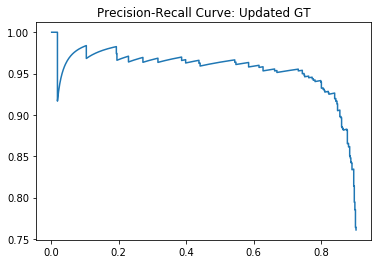

In [47]:
utils.draw_plot_xy(eval_res['rec'], eval_res['prec'], "Precision-Recall Curve: Updated GT")

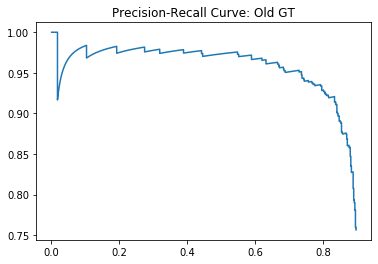

In [48]:
utils.draw_plot_xy(eval_res_old['rec'], eval_res_old['prec'], "Precision-Recall Curve: Old GT")

#### Check evaluation result per image against both updated and old ground truths

In [49]:
rows = []
rows_old = []

for filename in os.listdir(path_test_images)[:]:
    res = hbb_evaluator.evaluate_single_image(os.path.join(path_test_images, filename), all_gts[filename])
    res_old = hbb_evaluator.evaluate_single_image(os.path.join(path_test_images, filename), all_gts_old[filename])
    
    rows.append([filename, len(all_gts[filename]), res['tp'], res['fp'], res['fn']])
    rows_old.append([filename, len(all_gts_old[filename]), res_old['tp'], res_old['fp'], res_old['fn']])
    
df_result = pd.DataFrame(np.array(rows), columns=['filename', 'gt', 'tp', 'fp', 'fn'])
df_result_old = pd.DataFrame(np.array(rows_old), columns=['filename', 'gt_old', 'tp_old', 'fp_old', 'fn_old'])

In [50]:
print("Result of updated and old dataset (per image)")
display(df_result.merge(df_result_old, on="filename"))

Result of updated and old dataset (per image)


,filename,gt,tp,fp,fn,gt_old,tp_old,fp_old,fn_old
0,crop_1_crop_0_4955-compressed.png,33,30,5,3,32,29,6,3
1,crop_1_crop_0_964-compressed.png,17,17,2,0,16,16,3,0
2,crop_1_crop_0_747-compressed.png,22,18,4,4,23,18,4,5
3,crop_1_crop_0_96-compressed.png,37,31,9,6,37,32,8,5
4,crop_1_crop_0_905-compressed.png,36,31,8,5,38,33,6,5
5,crop_1_crop_0_698-compressed.png,20,20,4,0,20,20,4,0
6,crop_1_crop_0_4760-compressed.png,35,31,8,4,32,29,10,3
7,crop_1_crop_0_82-compressed.png,43,38,16,5,43,39,15,4
8,crop_1_crop_0_771-compressed.png,22,22,6,0,22,21,7,1
9,crop_1_crop_0_98-compressed.png,14,14,5,0,15,14,5,1


#### R2 score calculation

In [51]:
# y_true = df_result['gt'].to_numpy().astype(int)
# y_pred = df_result['tp'].to_numpy().astype(int) + df_result['fp'].to_numpy().astype(int)

# r2_scr = r2_score(y_true, y_pred)
# print("R2 Score (Against Updated GT): ", r2_scr)

# y_true = df_result_old['gt_old'].to_numpy().astype(int)
# y_pred = df_result_old['tp_old'].to_numpy().astype(int) + df_result_old['fp_old'].to_numpy().astype(int)

# r2_scr = r2_score(y_true, y_pred)
# print("R2 Score (Against Old GT): ", r2_scr)

## Evaluate HBB Model (Epoch 2000) Against RBB Ground Truth

#### Get rotated bounding boxes (ground truth)

In [52]:
df_rbb = pd.read_csv("/home/badhon/Documents/thesis/AerialDetection/data/wheat/test/test_dota.csv")

In [53]:
all_rgts_old = {}
for filename in os.listdir(path_test_images)[:]:
    all_rgts_old[filename] = df_rbb[df_rbb['filename'] == filename].to_numpy()[:,2:]

#### Evaluate the model against rotated GTs from old dataset

In [54]:
hbb_evaluator = Evaluator(path_config, path_work_dir, 2000)

In [55]:
eval_res = hbb_evaluator.evaluate_image_folder(path_test_images, None, all_rgts_old)

In [56]:
print("Evaluation of HBB Model Against OLD Test Dataset (RBB GT): ")
hbb_evaluator.print_summary(eval_res)

Evaluation of HBB Model Against OLD Test Dataset (RBB GT): 
tp:  406
fp:  239
fn:  176
gt:  582
ap:  0.5313564650489635


#### Precision-Recall Curve

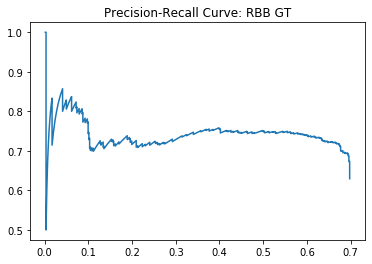

In [57]:
utils.draw_plot_xy(eval_res['rec'], eval_res['prec'], "Precision-Recall Curve: RBB GT")

#### Check evaluation result per image against old rotated ground truths

In [58]:
rows = []

for filename in os.listdir(path_test_images)[:]:
    res = hbb_evaluator.evaluate_single_image(os.path.join(path_test_images, filename), all_rgts_old[filename])
    rows.append([filename, len(all_rgts_old[filename]), res['tp'], res['fp'], res['fn']])
    
df_result = pd.DataFrame(np.array(rows), columns=['filename', 'gt', 'tp', 'fp', 'fn'])

In [59]:
print("Result of rotated old dataset (per image)")
display(df_result)

Result of rotated old dataset (per image)


,filename,gt,tp,fp,fn
0,crop_1_crop_0_4955-compressed.png,32,24,9,8
1,crop_1_crop_0_964-compressed.png,16,13,7,3
2,crop_1_crop_0_747-compressed.png,23,16,6,7
3,crop_1_crop_0_96-compressed.png,37,25,15,12
4,crop_1_crop_0_905-compressed.png,38,27,9,11
5,crop_1_crop_0_698-compressed.png,20,18,6,2
6,crop_1_crop_0_4760-compressed.png,32,28,9,4
7,crop_1_crop_0_82-compressed.png,43,27,23,16
8,crop_1_crop_0_771-compressed.png,22,10,15,12
9,crop_1_crop_0_98-compressed.png,15,10,9,5


#### R2 score calculation

In [60]:
# y_true = df_result['gt'].to_numpy().astype(int)
# y_pred = df_result['tp'].to_numpy().astype(int) + df_result['fp'].to_numpy().astype(int)

# r2_scr = r2_score(y_true, y_pred)
# print("R2 Score (Against Old RBB GT): ", r2_scr)